# snnTorch - Tutorial 1
### By Jason K. Eshraghian

<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/snntorch_alpha_w.png?raw=true' width="400">

# Spike Train Generation
In this tutorial, you will learn how to use snnTorch to:
* convert datasets into spiking datasets using various encoding methods, 
* how to visualise them, 
* and how to generate random spike trains.

If running in Google Colab:
* Ensure you are connected to GPU by checking `Runtime` > `Change runtime type` > `Hardware accelerator: GPU`
* Next, install the latest PyPi distribution of snnTorch by clicking into the following cell and pressing `Shift+Enter`.

In [1]:
!pip install snntorch

## 1. Setting up the MNIST Dataset
### 1.1. Import packages and setup environment

In [2]:
import snntorch as snn
import torch

Let's define a few variables.

`data_path` will be used as the target directory for downloading the training set.

`valid_split` will be used to assign data from the training set to the validation set.
*E.g., for a split of 0.1, the validation set will be made up of 10% of the train set.*

`subset` is used to partition the training and test sets down by the given factor.
*E.g., for a subset of 10, a training set of 60,000 will be reduced to 6,000.*

`num_steps` is the number of time steps to simulate.

In [3]:
# Training Parameters
batch_size=128
data_path='/data/mnist'
val_split = 0.1
subset = 10
num_outputs = 10

# Temporal Dynamics
num_steps = 100

# Torch Variables
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

### 1.2 Download Dataset

MNIST does not have a specified validation set by default. So we can make a copy of the training set in `mnist_val`.
We won't use `mnist_val` or `mnist_test` here - they're only to demonstrate creating a train-validation split.

In [4]:
from torchvision import datasets, transforms

# Define a transform
transform = transforms.Compose([
            transforms.Resize((28,28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_val = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

Extracting /data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /data/mnist/MNIST/raw


Extracting /data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /data/mnist/MNIST/raw


Extracting /data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/mnist/MNIST/raw


Extracting /data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/mnist/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


`snntorch.utils` contains a few useful functions for modifying datasets.
A train-validation split can be created by calling `valid_split`:

In [5]:
from snntorch import utils

mnist_train, mnist_val = utils.valid_split(mnist_train, mnist_val, val_split)

Until we actually start doing some training, we won't need large datasets.
So let's make our life simpler by reducing the size of the MNIST dataset.
We can apply `data_subset` to reduce the dataset by the factor given in the argument `subset`.


In [6]:
mnist_train = utils.data_subset(mnist_train, subset)
mnist_val = utils.data_subset(mnist_val, subset)
mnist_test = utils.data_subset(mnist_test, subset)

To verify, we can take a look at the length of each of our datasets:

In [7]:
print(f"The size of mnist_train is {len(mnist_train)}")
print(f"The size of mnist_val is {len(mnist_val)}")
print(f"The size of mnist_test is {len(mnist_test)}")

The size of mnist_train is 5400
The size of mnist_val is 600
The size of mnist_test is 1000


### 1.3 Create DataLoaders
DataLoaders in PyTorch return an iterator divided up into mini-batches of size ``batch_size``.

In [8]:
from torch.utils.data import DataLoader

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(mnist_val, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True)

## 2. Spike Encoding
MNIST is not a time-varying dataset. Spiking Neural Networks (SNNs) are made to exploit time-varying data.
This means that we have one of two options for passing input data into an SNN:

1. Directly feed the same static input features $x_i^{m}$ at each time step, where $x^{i}$ takes on an analog value $x^{i} \in$  [0, 1].
 This is like converting MNIST into a static, unchanging video.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_1_static.png?raw=true' width="600">
</center>

2. Convert the input into a spike train of sequence length `num_steps`, where $x^{i}$ takes on a discrete value $x^{i}
 \in$ {0, 1}.
In this case, MNIST would become a time-varying sequence of spikes that are related to the original image.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_2_spikeinput.png?raw=true' width="600">
</center>

The first method is quite straightforward, so let's consider (2) in more detail.

There are currently three options available for spike generation in `snntorch`:

1. Rate coding: `spikegen.rate`
2. Latency coding: `spikegen.latency`
3. Delta modulation: `spikegen.delta`

*Rate coding* uses input features to determine spiking frequency. *Latency coding* uses input features to determine spike timing. *Delta modulation* uses the temporal **change** of input features to generate spikes.

### 2.1 Spike rate coding of MNIST

Each input feature is used as the probability an event occurs, sampled from a binomial distribution. Formally, $X$~$B(n=1, p=x^{i})$ where the
**expected value** $\mathbb E[X]=x^{i}$ is simply the probability that a spike is generated at any given time step.
For an MNIST image, this probability corresponds to the pixel value. A white pixel corresponds to a 100% probability of spiking, and a black pixel will never generate a spike.


<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_3_spikeconv.png?raw=true' width="600">
</center>


In [9]:
from snntorch import spikegen

# Iterate through minibatches
data = iter(train_loader)
data_it, targets_it = next(data)
data_it = data_it.to(device)
targets_it = targets_it.to(device)

# Spiking Data
spike_data, spike_targets = spikegen.rate(data_it, targets_it, num_outputs=num_outputs, num_steps=num_steps,
                                                      gain=1, offset=0, one_hot=False, time_varying_targets=False)

As you can see, `spikegen.rate` takes a few arguments that can modify spiking probability:

* `gain` multiplies the input by the given factor, and
* `offset` applies a level-shift to the input.

If the result falls outside of [0,1], then it will automatically be clipped such that the feature represents a probability.

Note: there are also options to convert targets to one hot encodings using `one_hot`, and to extend the encodings along the time-axis using `time_varying_targets`.
Both are set to `False`, so `targets_it` is passed directly to `spike_targets`.

The structure of the input data is ``[num_steps x batch_size x input dimensions]``:

In [10]:
print(spike_data.size())

torch.Size([100, 128, 1, 28, 28])


#### 2.2 Visualization
##### 2.2.1 Animation
snnTorch contains a module `spikeplot` that can simplify the process of visualizing, plotting, and animating spiking neurons.


In [16]:
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

To plot one sample of data, we have to index into the batch (B) dimension of `spike_data`, ``[T x B x 1 x 28 x 28]``:

In [18]:
spike_data_sample = spike_data[:, 0, 0]
print(spike_data_sample.size())

torch.Size([100, 28, 28])


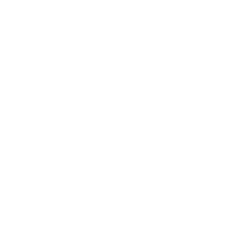

In [19]:
spike_data_sample = spike_data[:, 0, 0]
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample, fig, ax)

HTML(anim.to_html5_video())

In [21]:
# If you're feeling sentimental, you can save the animation: .gif, .mp4 etc.
anim.save("spike_mnist_test.mp4")

The associated target label can be indexed as follows:

In [22]:
print(f"The corresponding target is: {spike_targets[0]}")

The corresponding target is: 2


As a matter of interest, let's do that again but with 25% of the gain to promote sparsity. This time, we won't bother passing the targets into `spikegen.rate`, as we don't need it.

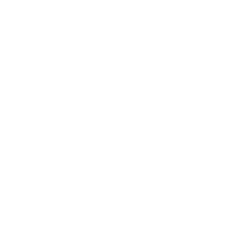

In [25]:
spike_data = spikegen.rate(data_it, num_outputs=num_outputs, num_steps=num_steps, gain=0.25, offset=0)

spike_data_sample2 = spike_data[:, 0, 0]
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample2, fig, ax)
HTML(anim.to_html5_video())

In [27]:
# Uncomment for optional save
# anim.save("spike_mnist_test2.mp4")

Now let's average the spikes out over time and reconstruct the input images.

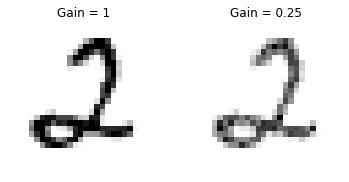

In [30]:
plt.figure(facecolor="w")
plt.subplot(1,2,1)
plt.imshow(spike_data_sample.mean(axis=0).reshape((28,-1)).cpu(), cmap='binary')
plt.axis('off')
plt.title('Gain = 1')

plt.subplot(1,2,2)
plt.imshow(spike_data_sample2.mean(axis=0).reshape((28,-1)).cpu(), cmap='binary')
plt.axis('off')
plt.title('Gain = 0.25')

plt.show()

The case where `gain=0.25` is much lighter than where `gain=1`, as spiking probability has been reduced by a factor of x4.

##### 2.2.2 Raster Plots
Alternatively, we can generate a raster plot of an input sample. This requires reshaping our sample.

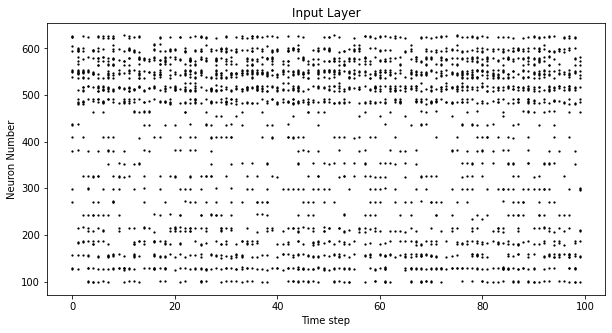

In [32]:
# Reshape
spike_data_sample2 = spike_data_sample2.reshape((num_steps, -1))

# raster plot
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data_sample2, ax, s=1.5, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

We can also index into one single neuron. Below, we are indexing into the 210th neuron.
Depending on your input data, you may need to index into a few different neurons between 0 & 784 before finding one that spikes.


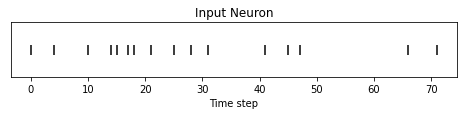

In [40]:
fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

splt.raster(spike_data_sample.reshape(num_steps, -1)[:,210].unsqueeze(1), ax, s=100, c="black", marker="|")

plt.title("Input Neuron")
plt.xlabel("Time step")
plt.yticks([])
plt.show()

This covers the `spikegen.rate` function. 

For examples to convert targets into one-hot-encodings, refer to the snnTorch documentation. 

### 2.2 Latency Coding of MNIST
Rate coding is quite controversial. Multiple spikes are needed to achieve any sort of task, and so more power may be consumed than is necessary. It is unlikely to be the only mechanism going on in the brain. 

Temporal codes capture information about the precise firing time of neurons; a single spike carries much more meaning than in rate codes which rely on firing frequency.
While this opens up more susceptibility to noise, it can also decrease the power consumed by the hardware running SNN algorithms because the need for multiple spikes is mitigated.

`spikegen.latency` is a function that allows each input to fire at most **once** during the full time sweep.
Features closer to `1` will fire earlier and features closer to `0` will fire later. I.e., in our MNIST case, bright pixels will fire earlier and dark pixels will fire later.

In [41]:
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01, clip=False,
                              normalize=False, linear=False)

* `tau`: by default, the input features are treated as a constant current injected into an RC circuit. `tau` is the RC time constant of the circuit. A higher `tau` will induce slower firing.
* `threshold`: the membrane potential the RC circuit must charge to before it can fire. All features below the threshold are saturated.
* `clip`: if `True`, spikes below the `threshold` are removed.
* `normalize`: if `True`, the full range of firing is extended or squashed to fit `num_steps`.
* `linear`: if True, the logarithmic firing latency of the RC circuit is replaced with a linear firing latency.

### 2.2.1 Raster plot
We'll start with a raster this time.

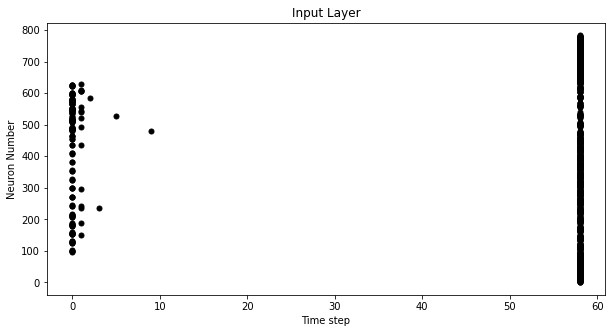

In [48]:
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

fig.savefig('destination_path.png', format='png', dpi=300)

To make sense of your raster plot, you'll notice that high intensity features fire first, whereas low intensity features fire last:

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_5_latencyraster.png?raw=true' width="600">
</center>

The logarithmic code coupled with the lack of diverse input values (i.e., the lack of midtone/grayscale features) causes significant clustering in two areas of the plot.
The bright pixels induce firing at the start of the run, and the dark pixels at the end.
We can increase `tau` to slow this down, or we can linearize the data by setting `linear=True`.

In [ ]:
spike_data, spike_targets = spikegen.latency(data_it, targets_it, num_steps=100, tau=5, threshold=0.01, clip=False,
                                              normalize=False, linear=True, convert_targets=False, temporal_targets=False)

fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
ax.scatter(*torch.where(spike_data[:, 0].view(100, -1).cpu()), s=25, c="black")
plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

The spread of firing times is much more evenly distributed now. But notice all firing occurs within the first ~5 time steps, whereas the simulation range is 100 time steps.
This indicates that we have a lot of redundant time steps doing nothing. This can be solved by either increasing `tau` to slow down the time constant, or setting `normalize=True` to span the full range of `num_steps`.

In [ ]:
spike_data, spike_targets = spikegen.latency(data_it, targets_it, num_steps=100, tau=5, threshold=0.01, clip=False,
                                              normalize=True, linear=True, convert_targets=False, temporal_targets=False)

fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
ax.scatter(*torch.where(spike_data[:, 0].view(100, -1).cpu()), s=25, c="black")
plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

One major advantage of spike-driven data is their sparsity, and their event-driven behavior.
In the scenario shown above, a majority of the spikes occur at the final time step, where the input features fall below the threshold.
We can remove these redundant features by setting `clip=True`.

In [ ]:
spike_data, spike_targets = spikegen.latency(data_it, targets_it, num_steps=100, tau=5, threshold=0.01, clip=True,
                                              normalize=True, linear=True, convert_targets=False, temporal_targets=False)

fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
ax.scatter(*torch.where(spike_data[:, 0].view(100, -1).cpu()), s=25, c="black")
plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

That looks much better!

### 2.2.2 Animation
We will run the exact same code block as before to create an animation.

In [ ]:
spike_data_sample = spike_data[:, 0, 0]
print(spike_data_sample.size())

In [ ]:
spike_data_sample = spike_data_sample.cpu()

fig, ax = plt.subplots()
camera = Camera(fig)
plt.axis('off')

# iterate over time and take a snapshot with celluloid
for time in range(num_steps):
    im = ax.imshow(spike_data_sample[time, :, :], cmap='plasma')
    camera.snap()

# interval=100 specifies 100ms delay between frames
anim = camera.animate(interval=100)
HTML(anim.to_html5_video())

In [ ]:
# Save output: .gif, .mp4 etc.
anim.save("mnist_latency.gif")

This animation is obviously much tougher to make out in video form, but a keen eye will be able to catch a glimpse of the initial frame where most of the spikes occur.
We can index into the corresponding target value to check what value it is.

In [ ]:
print(spike_targets[0])

## 3. Spike Generation
Now say we just want a randomly generated spike train from scratch.
`spikegen.rate` has a nested function, `rate_conv` which takes care of the feature $\rightarrow$ spike conversion process.
All we have to do is initialize a randomly generated `torchTensor` to pass in.

In [ ]:
# Create a random spike train
spike_prob = torch.rand((num_steps, 28, 28), device=device, dtype=dtype) * 0.5
spike_rand = spikegen.rate_conv(spike_prob)

3.1 Animation

In [ ]:
spike_data = spike_data.cpu()

fig, ax = plt.subplots()
camera = Camera(fig)
plt.axis('off')

# iterate over time and take a snapshot with celluloid
for time in range(num_steps):
    im = ax.imshow(spike_rand[time, :, :], cmap='plasma')
    camera.snap()

# interval=40 specifies 40ms delay between frames
anim = camera.animate(interval=40)
HTML(anim.to_html5_video())

In [ ]:
# Save output: .gif, .mp4 etc.
anim.save("random_spikes.gif")

3.2 Raster

In [ ]:
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
ax.scatter(*torch.where(spike_rand[:, 0].view(100, -1).cpu()), s=25, c="black")
plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

That's it for spike conversion and generation. 
This approach generalizes beyond images, to single-dimensional and multi-dimensional tensors.
Next up, we'll try to do some learning using both static MNIST and our own generated spiking MNIST.